In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import binom, beta, norm, uniform

In [3]:
# Given data and priors
data = np.array([10, 15, 15, 14, 14, 14, 13, 11, 12, 16])
n = 20
N = len(data)
sum_y = np.sum(data)
# Model 1: Beta(6, 6) prior
alpha1_prior = 6
beta1_prior = 6
alpha1_post = alpha1_prior + sum_y
beta1_post = beta1_prior + (N * n - sum_y)
# Model 2: Beta(20, 60) prior
alpha2_prior = 20
beta2_prior = 60
alpha2_post = alpha2_prior + sum_y
beta2_post = beta2_prior + N * n - sum_y

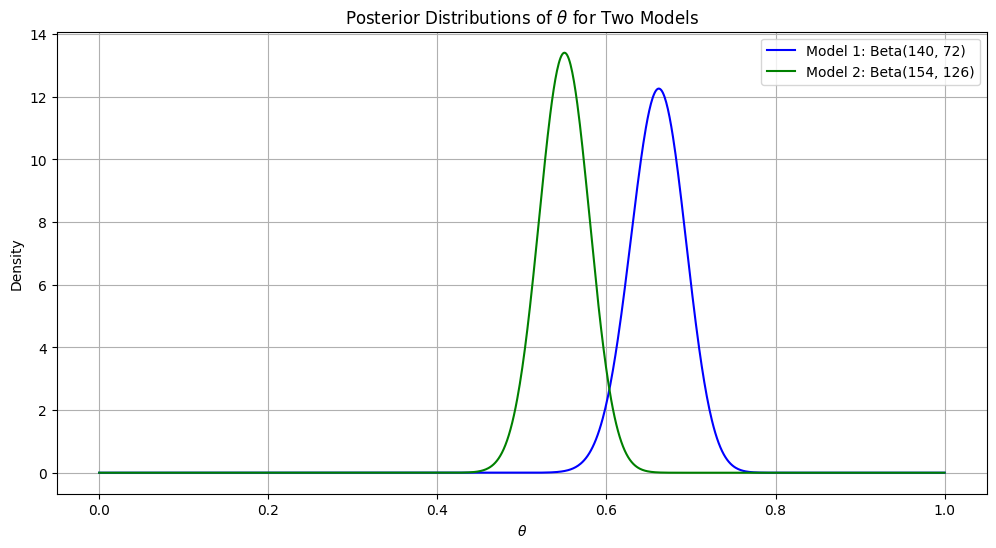

In [4]:
# Define theta range for plotting
theta = np.linspace(0, 1, 1000)
# Posterior distributions
posterior1 = beta.pdf(theta, alpha1_post, beta1_post)
posterior2 = beta.pdf(theta, alpha2_post, beta2_post)
# Plotting the posteriors
plt.figure(figsize=(12, 6))
plt.plot(theta, posterior1, label=f'Model 1: Beta({alpha1_post}, {beta1_post})', color='blue')
plt.plot(theta, posterior2, label=f'Model 2: Beta({alpha2_post}, {beta2_post})', color='green')
plt.title('Posterior Distributions of $\\theta$ for Two Models')
plt.xlabel('$\\theta$')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Q2:

fold_count = 5
indices = np.arange(N)
random.shuffle(indices.tolist())
fold_parts = np.array_split(indices, fold_count)

def compute_lppd(a_prior, b_prior):
    lppd_scores = np.zeros(fold_count)
    for f in range(fold_count):
        test_idx  = fold_parts[f]
        train_idx = np.setdiff1d(indices, test_idx)

        y_train = data[train_idx]
        y_test  = data[test_idx]

        # update posterior hyperparameters
        alpha_post = a_prior + y_train.sum()
        beta_post  = b_prior + y_train.size * n - y_train.sum()

        # draw from the Beta posterior
        theta_samples = np.random.beta(alpha_post, beta_post, size=1000)

        # accumulate log‐predictive densities
        lppd_fold = 0.0
        for y_obs in y_test:
            lppd_fold += np.log(np.mean(binom.pmf(y_obs, n, theta_samples)))
        lppd_scores[f] = lppd_fold

    return lppd_scores

# Model 1: Beta(6,6)
lppd_1 = compute_lppd(6, 6)
elpd_1 = lppd_1.sum()

# Model 2: Beta(20,60)
lppd_2 = compute_lppd(20, 60)
elpd_2 = lppd_2.sum()

print(f"Model 1 ELPD: {elpd_1:.4f}")
print(f"Model 2 ELPD: {elpd_2:.4f}")

Model 1 ELPD: -20.9274
Model 2 ELPD: -28.1489


In [13]:
# Q3:
dev_1 = -2 * elpd_1
dev_2 = -2 * elpd_2

print(f"Model 1 In-sample Deviance: {dev_1:.4f}")
print(f"Model 2 In-sample Deviance: {dev_2:.4f}")

# Explanation: in-sample deviance assesses how well each model fits its own training data.
# Since deviance = –2 × (log‐predictive density), lower values indicate predictions that
# more closely match the observed outcomes, reflecting better in-sample fit.

Model 1 In-sample Deviance: 41.8549
Model 2 In-sample Deviance: 56.2977


In [14]:
# Q4:
winner = "Model 1" if dev_1 < dev_2 else "Model 2"
print(f"{winner} exhibits the lower in-sample deviance, implying it fits the observed data more closely.")

Model 1 exhibits the lower in-sample deviance, implying it fits the observed data more closely.


In [29]:
# Q5:
test_data = np.array([5, 6, 10, 8, 9])
n_test = len(test_data)

def compute_total_lppd(values, theta_samples, trials):
    total = 0.0
    for y_obs in values:
        total += np.log(np.mean(binom.pmf(y_obs, trials, theta_samples)))
    return total

# draw from the full‐data posterior for each model
theta1_full = np.random.beta(alpha1_post, beta1_post, size=1000)
theta2_full = np.random.beta(alpha2_post, beta2_post, size=1000)

# compute lppd for the new data
lppd1_new = compute_total_lppd(test_data, theta1_full, n)
lppd2_new = compute_total_lppd(test_data, theta2_full, n)

# convert to deviance
dev1_out = -2 * lppd1_new
dev2_out = -2 * lppd2_new

print(f"Model 1 lppd: {lppd1_new:.4f}")
print(f"Model 1 out-of-sample deviance: {dev1_out:.4f}")
print(f"Model 2 lppd: {lppd2_new:.4f}")
print(f"Model 1 out-of-sample deviance: {dev2_out:.4f}")

Model 1 lppd: -11.6407
Model 1 out-of-sample deviance: 23.2815
Model 2 lppd: -15.1275
Model 1 out-of-sample deviance: 30.2550


In [16]:
# Q6:
def compute_loo_elpd(a_prior, b_prior):
    total_elpd = 0.0
    for i in range(N):
        # leave out the i-th observation
        train = np.delete(data, i)
        test  = data[i]

        # update posterior with N-1 data points
        alpha_p = a_prior + train.sum()
        beta_p  = b_prior  + (N - 1) * n - train.sum()

        # sample from the Beta posterior
        theta_samples = np.random.beta(alpha_p, beta_p, size=1000)

        # accumulate log predictive density for the held-out point
        total_elpd += np.log(np.mean(binom.pmf(test, n, theta_samples)))

    return total_elpd

# compute LOO-CV elpd for each prior choice
elpd1_loo = compute_loo_elpd(6, 6)
elpd2_loo = compute_loo_elpd(20, 60)

print(f"Model 1 LOO-CV elpd: {elpd1_loo:.4f}")
print(f"Model 2 LOO-CV elpd: {elpd2_loo:.4f}")

# interpretation:
# the model with the larger LOO-CV elpd is expected to generalize better

Model 1 LOO-CV elpd: -21.1614
Model 2 LOO-CV elpd: -27.2061


In [21]:
# Function to calculate the marginal likelihood
def ML_binomial(k, n, a, b):
    ML = (math.factorial(n) / (math.factorial(k) * math.factorial(n - k))) * (
            math.factorial(k + a - 1) * math.factorial(n - k + b - 1) / math.factorial(n + a + b - 1)
    )
    return ML

k = 2
n = 10
a_ = 0.1
b_ = 0.4

priors = {
    "Beta_1_1": (1, 1),
    "Beta_2_6": (2, 6),
    "Beta_6_2": (6, 2),
    "Beta_20_60": (20, 60),
    "Beta_60_20": (60, 20)
}

print(f"Marginal Likelihood for (Beta({a_}, {b_})): {ml:.2e}")
for name,(a, b) in priors.items():
    marginal_likelihood = ML_binomial(k, n, a, b)
    print(f"Marginal Likelihood for (Beta({a}, {b})): {marginal_likelihood:.2e}")

Marginal Likelihood for (Beta(0.1, 0.4)): 3.60e-02
Marginal Likelihood for (Beta(1, 1)): 9.09e-02
Marginal Likelihood for (Beta(2, 6)): 4.73e-03
Marginal Likelihood for (Beta(6, 2)): 2.31e-04
Marginal Likelihood for (Beta(20, 60)): 5.08e-21
Marginal Likelihood for (Beta(60, 20)): 1.51e-23


In [19]:
# Define the list of Beta priors to use
priors = {
    "Beta_0.1_0.4": (0.1, 0.4),
    "Beta_1_1":     (1,   1),
    "Beta_2_6":     (2,   6),
    "Beta_6_2":     (6,   2),
    "Beta_20_60":   (20,  60),
    "Beta_60_20":   (60,  20)
}

def monte_carlo_ml(alpha, beta_param, k_obs, n_trials, iterations=10_000, proposal_sd=0.08):
    chain = np.empty(iterations)
    chain[0] = 0.4
    likelihood_accum = 0.0

    for t in range(1, iterations):
        candidate = np.random.normal(chain[t-1], proposal_sd)
        if 0 < candidate < 1:
            post_candidate = binom.pmf(k_obs, n_trials, candidate) * beta.pdf(candidate, alpha, beta_param)
            post_current   = binom.pmf(k_obs, n_trials, chain[t-1]) * beta.pdf(chain[t-1], alpha, beta_param)
            q_forward      = norm.pdf(chain[t-1], candidate, proposal_sd)
            q_backward     = norm.pdf(candidate, chain[t-1], proposal_sd)

            accept_ratio = (post_candidate * q_forward) / (post_current * q_backward)
            if np.random.rand() < min(1, accept_ratio):
                chain[t] = candidate
                likelihood_accum += post_candidate / q_backward
            else:
                chain[t] = chain[t-1]
        else:
            chain[t] = chain[t-1]

    return likelihood_accum / iterations

# Evaluate and print estimates
for label, (a, b) in priors.items():
    mc_estimate = monte_carlo_ml(a, b, k_obs=2, n_trials=10)
    print(f"{label} MC marginal likelihood: {mc_estimate:.2e}")

Beta_0.1_0.4 MC marginal likelihood: 2.97e-02
Beta_1_1 MC marginal likelihood: 7.74e-02
Beta_2_6 MC marginal likelihood: 1.58e-01
Beta_6_2 MC marginal likelihood: 7.90e-03
Beta_20_60 MC marginal likelihood: 2.21e-01
Beta_60_20 MC marginal likelihood: 6.48e-04
